<a href="https://colab.research.google.com/github/Mu-niu13/AIPI-590-HWs/blob/main/Human-AI%20Interaction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AIPI 590 - XAI | Human-AI Interaction

### Mu Niu

Claude Sonnet 4.5 is used to help with coding, while interpretation on the results are my own words

#### Load Libs

In [ ]:
# pip install grad-cam
import torch
import torch.nn.functional as F
from torchvision.models import resnet50
from torchvision import transforms
from pytorch_grad_cam import GradCAM, GradCAMPlusPlus, HiResCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import requests
from io import BytesIO
import warnings
warnings.filterwarnings('ignore')

# check gpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


#### Load Model: ResNet50 and CV methods

In [ ]:
# Load model
model = resnet50(pretrained=True)
model.eval()
model = model.to(device)
target_layers = [model.layer4[-1]]

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 138MB/s]


In [ ]:
# Initialize CAM methods
use_cuda = torch.cuda.is_available()

cam_gradcam = GradCAM(model=model, target_layers=target_layers)
cam_gradcam_pp = GradCAMPlusPlus(model=model, target_layers=target_layers)
cam_hirescam = HiResCAM(model=model, target_layers=target_layers)

#### Load Image Data

In [ ]:
# Image preprocessing
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load ImageNet labels
url = "https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt"
try:
    class_labels = requests.get(url).text.strip().split('\n')
except:
    class_labels = [f"Class_{i}" for i in range(1000)]

# Wildlife images to analyze
wildlife_images = [
    {
        'url': 'https://images.unsplash.com/photo-1564349683136-77e08dba1ef7?w=800',
        'description': 'African Zebra',
        'note': 'Grévy\'s zebra is endangered'
    },
    {
        'url': 'https://images.unsplash.com/photo-1551316679-9c6ae9dec224?w=800',
        'description': 'African Elephant',
        'note': 'Listed as endangered due to poaching'
    },
    {
        'url': 'https://images.unsplash.com/photo-1614027164847-1b28cfe1df60?w=800',
        'description': 'Lion',
        'note': 'Vulnerable status, declining populations'
    },
    {
        'url': 'https://images.unsplash.com/photo-1602491453631-e2a5ad90a131?w=800',
        'description': 'Tiger',
        'note': 'Only ~3,900 tigers left in the wild'
    },
    {
        'url': 'https://images.unsplash.com/photo-1564760055775-d63b17a55c44?w=800',
        'description': 'Giant Panda',
        'note': 'Recovered from endangered to vulnerable'
    }
]

#### Visualization


[1/5] African Zebra - Grévy's zebra is endangered
────────────────────────────────────────────────────────────────────────────────
Prediction: giant panda (100.0% confidence)
Top 5: giant panda (100.0%), lesser panda (0.0%), soccer ball (0.0%), indri (0.0%), teddy (0.0%)
✓ Saved to wildlife_analysis_1.png


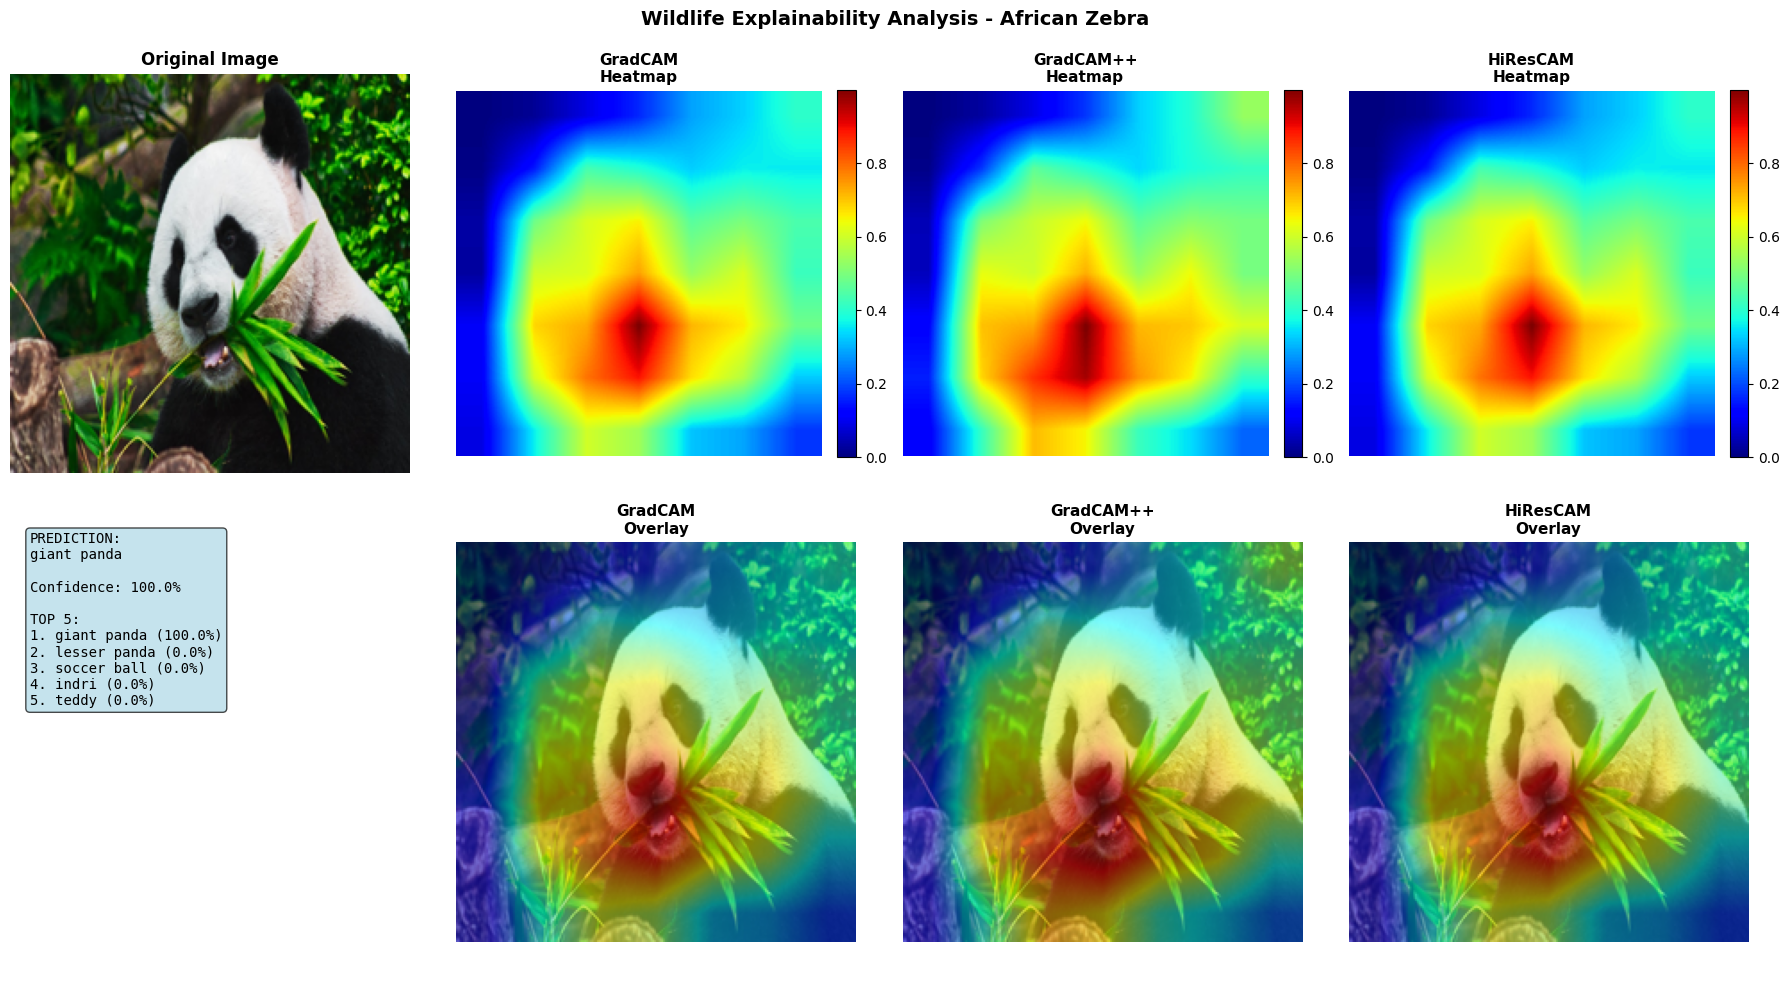


[2/5] African Elephant - Listed as endangered due to poaching
────────────────────────────────────────────────────────────────────────────────
Prediction: Indian elephant (92.8% confidence)
Top 5: Indian elephant (92.8%), tusker (5.9%), water buffalo (0.3%), African elephant (0.2%), ram (0.2%)
✓ Saved to wildlife_analysis_2.png


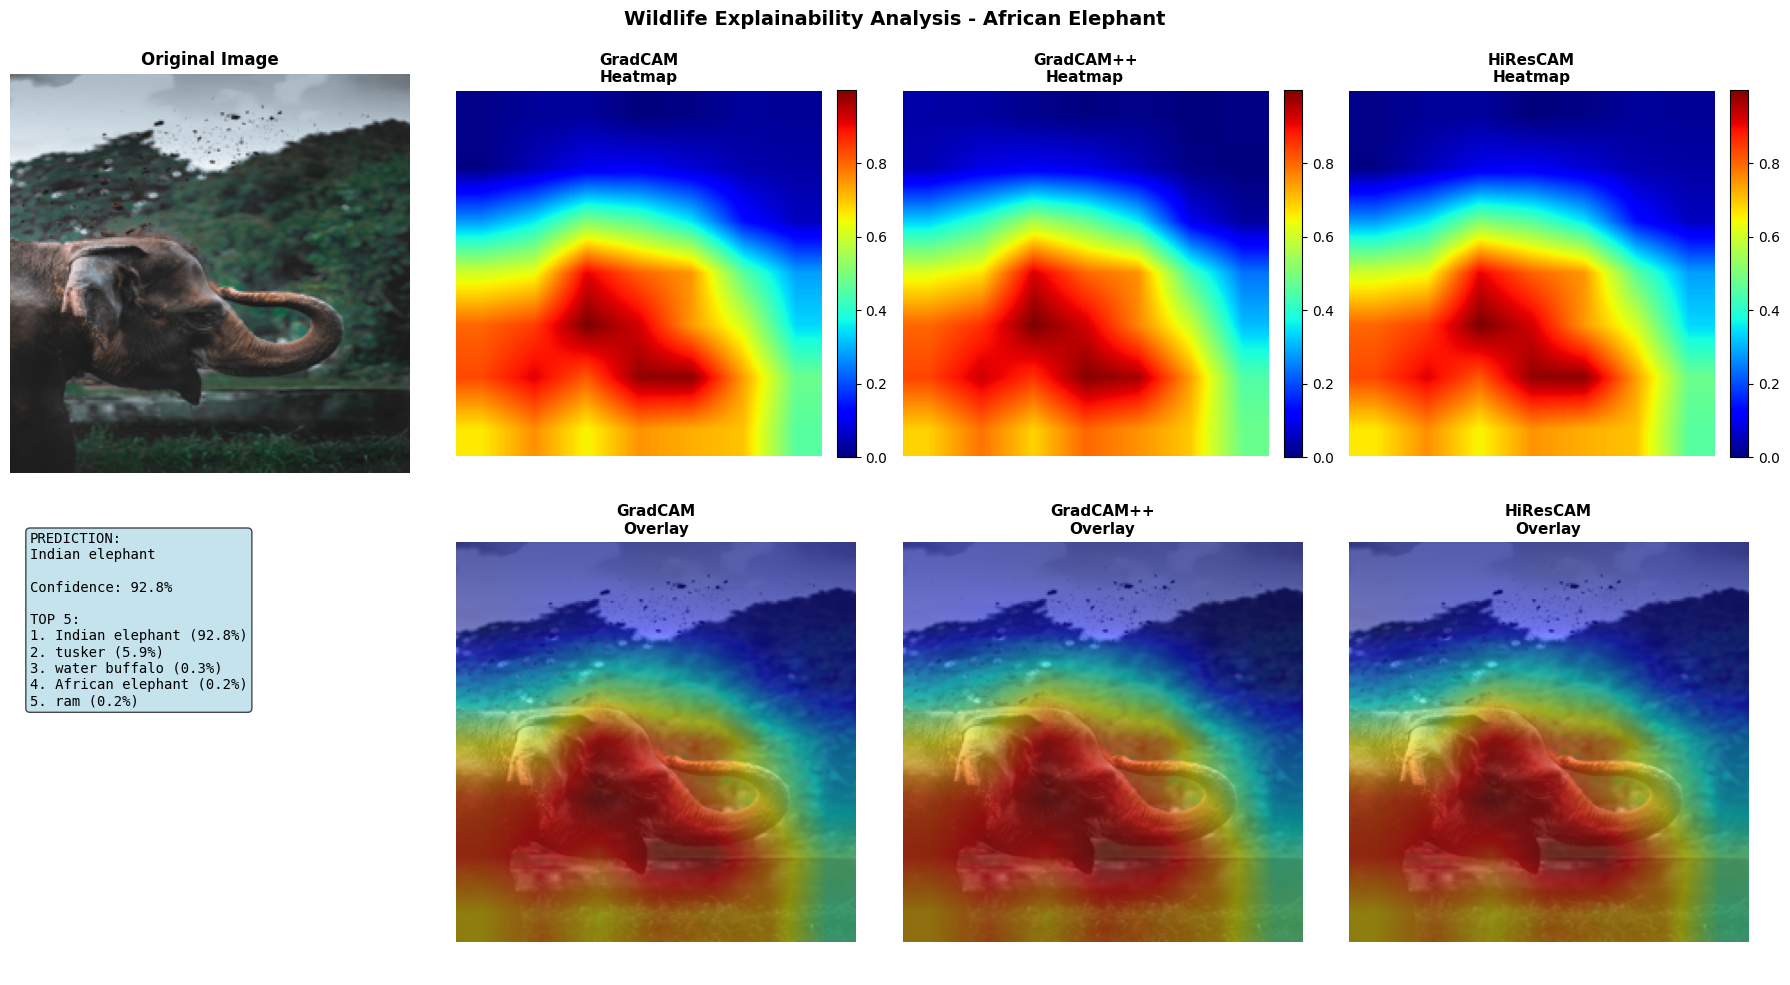


[3/5] Lion - Vulnerable status, declining populations
────────────────────────────────────────────────────────────────────────────────
Prediction: lion (100.0% confidence)
Top 5: lion (100.0%), lynx (0.0%), chow (0.0%), Persian cat (0.0%), leopard (0.0%)
✓ Saved to wildlife_analysis_3.png


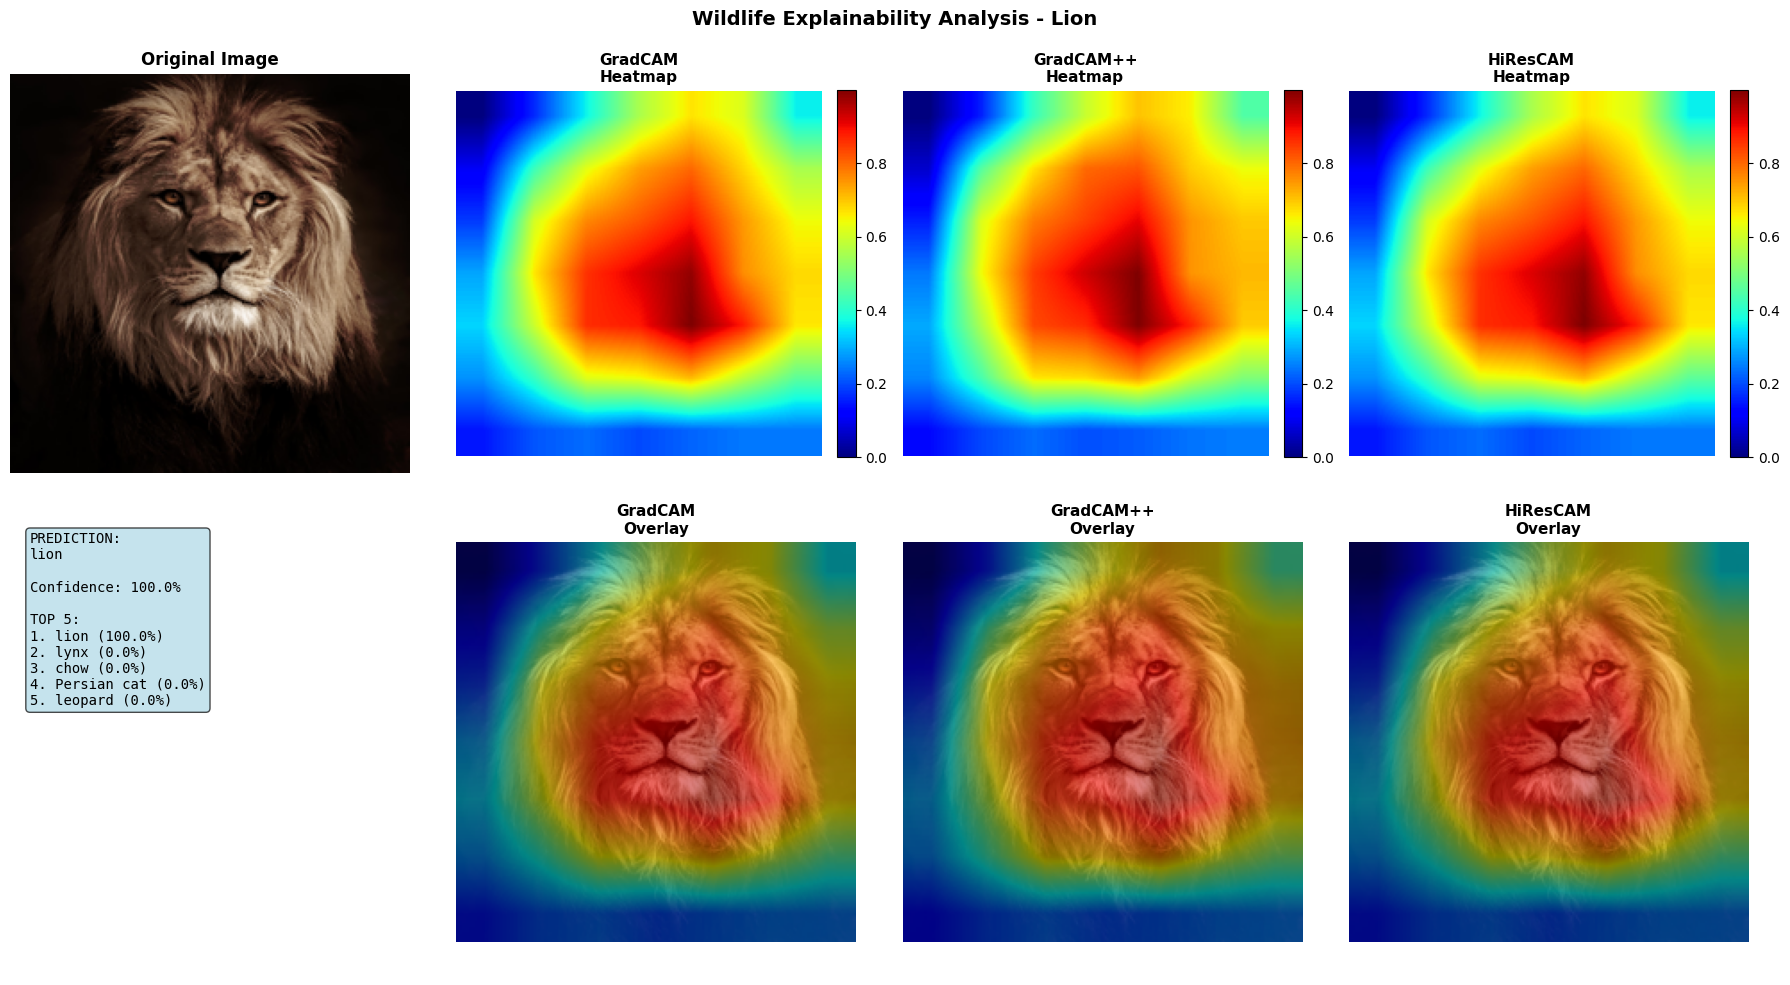


[4/5] Tiger - Only ~3,900 tigers left in the wild
────────────────────────────────────────────────────────────────────────────────
Prediction: tiger (89.7% confidence)
Top 5: tiger (89.7%), tiger cat (10.2%), jaguar (0.0%), Egyptian cat (0.0%), tabby (0.0%)
✓ Saved to wildlife_analysis_4.png


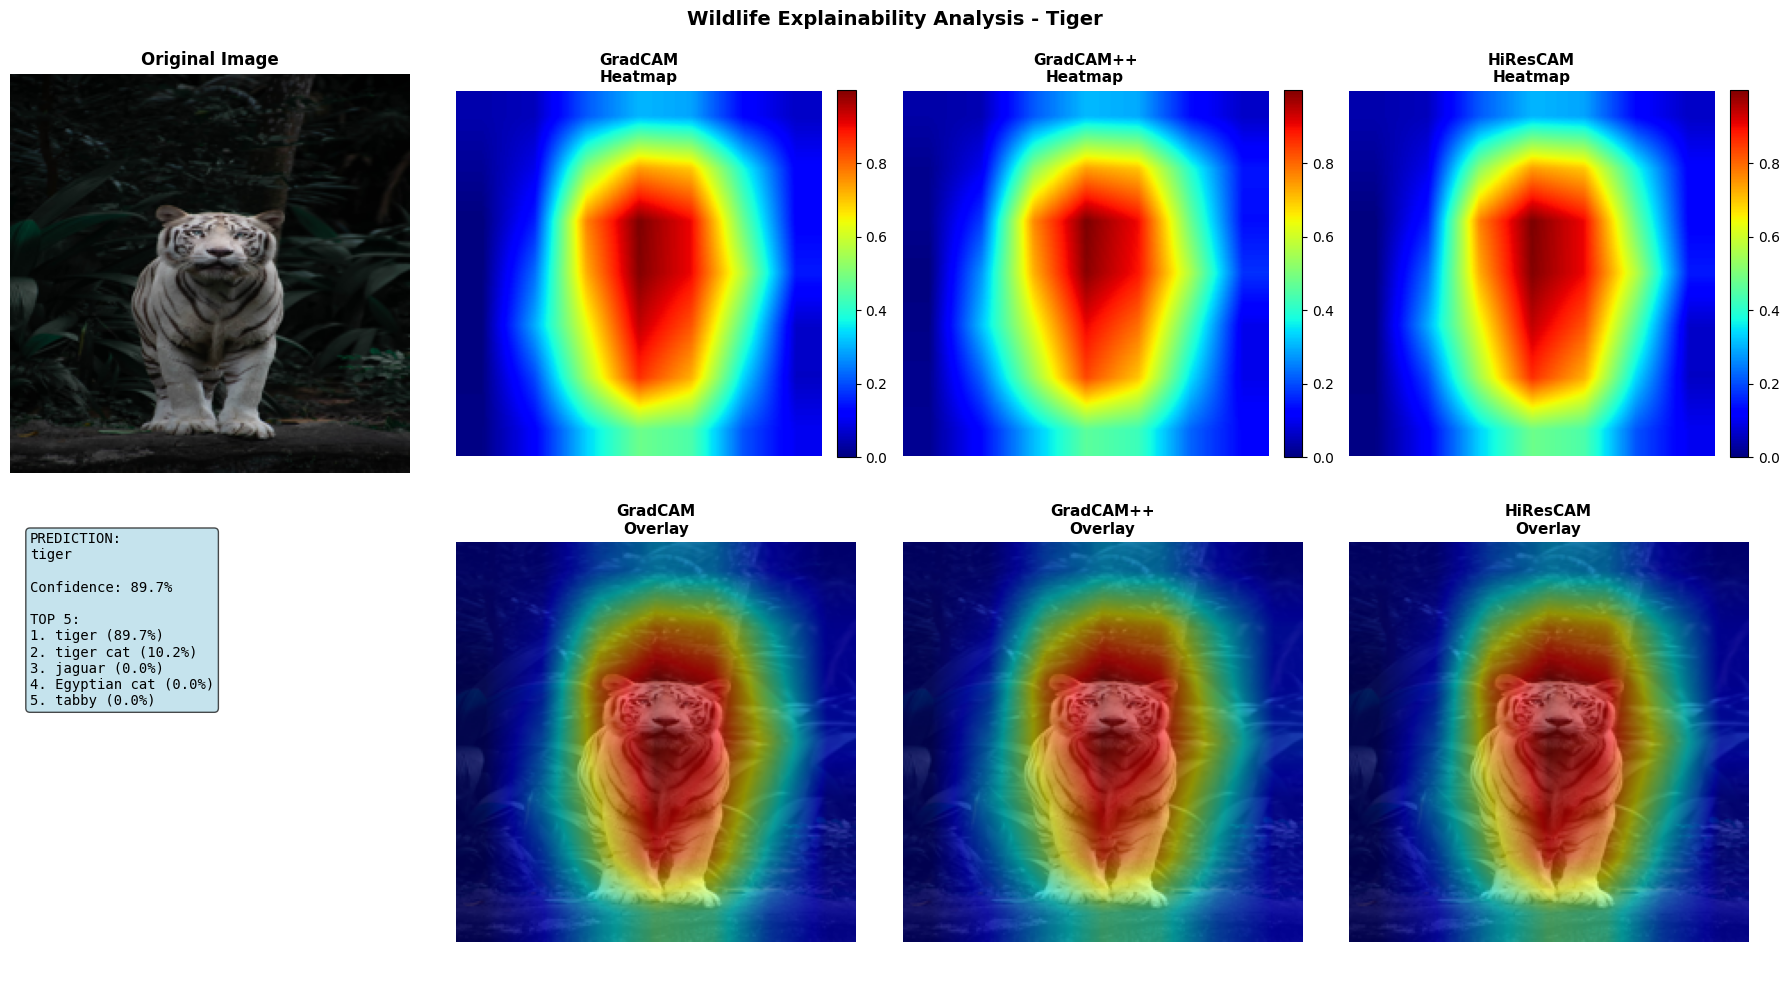


[5/5] Giant Panda - Recovered from endangered to vulnerable
────────────────────────────────────────────────────────────────────────────────
Prediction: African elephant (83.8% confidence)
Top 5: African elephant (83.8%), tusker (10.5%), Indian elephant (5.6%), warthog (0.0%), triceratops (0.0%)
✓ Saved to wildlife_analysis_5.png


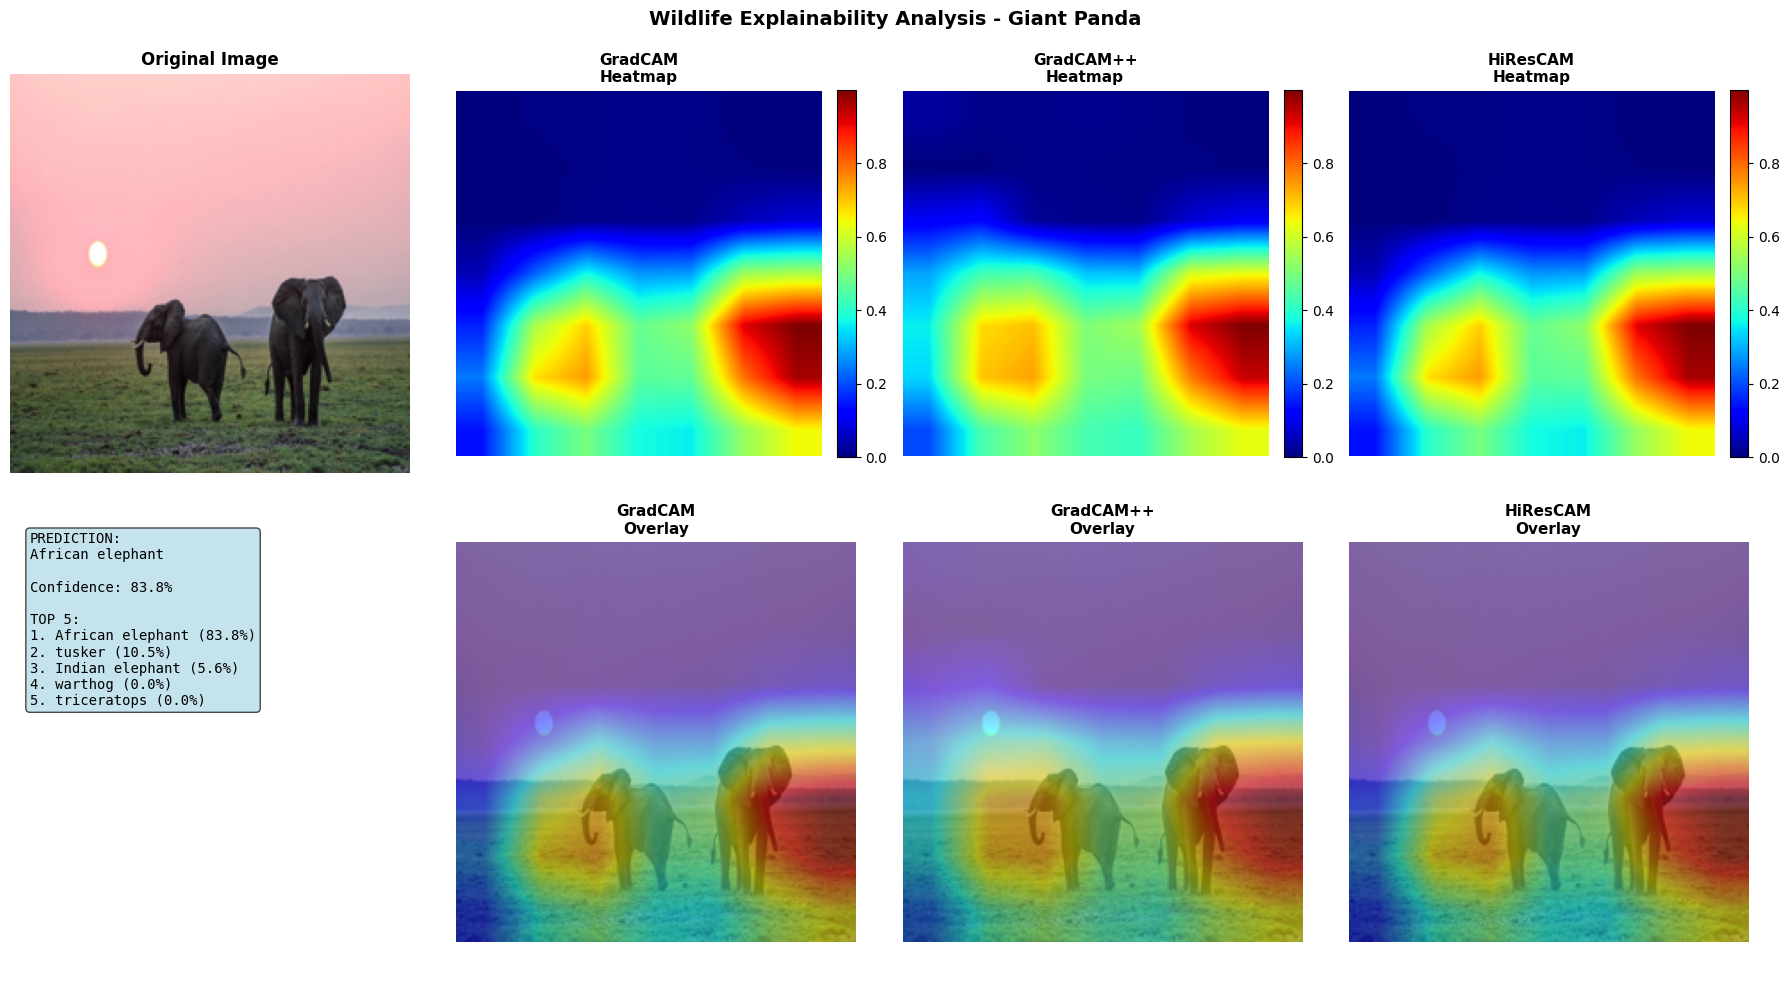

In [ ]:
all_results = []

# Process each image
for i, img_info in enumerate(wildlife_images, 1):
    print(f"\n[{i}/{len(wildlife_images)}] {img_info['description']} - {img_info['note']}")
    print("─" * 80)

    try:
        # Load image
        response = requests.get(img_info['url'], timeout=10)
        pil_img = Image.open(BytesIO(response.content)).convert('RGB')

        # Prepare image
        rgb_img = np.array(pil_img.resize((224, 224))) / 255.0
        rgb_img = rgb_img.astype(np.float32)
        input_tensor = preprocess(pil_img).unsqueeze(0).to(device)

        # Get predictions
        with torch.no_grad():
            output = model(input_tensor)
            probs = F.softmax(output, dim=1)
            top5_prob, top5_idx = torch.topk(probs, 5)

        top5_prob = top5_prob[0].cpu().numpy()
        top5_idx = top5_idx[0].cpu().numpy()
        top5_classes = [class_labels[idx] for idx in top5_idx]

        print(f"Prediction: {top5_classes[0]} ({top5_prob[0]:.1%} confidence)")
        print(f"Top 5: {', '.join([f'{c} ({p:.1%})' for c, p in zip(top5_classes, top5_prob)])}")

        # Generate CAMs
        targets = [ClassifierOutputTarget(top5_idx[0])]

        grayscale_gradcam = cam_gradcam(input_tensor=input_tensor, targets=targets)[0, :]
        grayscale_gradcam_pp = cam_gradcam_pp(input_tensor=input_tensor, targets=targets)[0, :]
        grayscale_hirescam = cam_hirescam(input_tensor=input_tensor, targets=targets)[0, :]

        vis_gradcam = show_cam_on_image(rgb_img, grayscale_gradcam, use_rgb=True)
        vis_gradcam_pp = show_cam_on_image(rgb_img, grayscale_gradcam_pp, use_rgb=True)
        vis_hirescam = show_cam_on_image(rgb_img, grayscale_hirescam, use_rgb=True)

        # Visualize
        fig = plt.figure(figsize=(18, 10))

        # Original and predictions
        ax1 = plt.subplot(2, 4, 1)
        ax1.imshow((rgb_img * 255).astype(np.uint8))
        ax1.set_title('Original Image', fontsize=12, fontweight='bold')
        ax1.axis('off')

        ax2 = plt.subplot(2, 4, 5)
        ax2.axis('off')
        pred_text = f"PREDICTION:\n{top5_classes[0]}\n\nConfidence: {top5_prob[0]:.1%}\n\n"
        pred_text += "TOP 5:\n" + '\n'.join([f"{j+1}. {c} ({p:.1%})"
                                             for j, (c, p) in enumerate(zip(top5_classes, top5_prob))])
        ax2.text(0.05, 0.95, pred_text, fontsize=10, verticalalignment='top',
                family='monospace', bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.7))

        # GradCAM
        ax3 = plt.subplot(2, 4, 2)
        im3 = ax3.imshow(grayscale_gradcam, cmap='jet')
        ax3.set_title('GradCAM\nHeatmap', fontsize=11, fontweight='bold')
        ax3.axis('off')
        plt.colorbar(im3, ax=ax3, fraction=0.046, pad=0.04)

        ax7 = plt.subplot(2, 4, 6)
        ax7.imshow(vis_gradcam)
        ax7.set_title('GradCAM\nOverlay', fontsize=11, fontweight='bold')
        ax7.axis('off')

        # GradCAM++
        ax4 = plt.subplot(2, 4, 3)
        im4 = ax4.imshow(grayscale_gradcam_pp, cmap='jet')
        ax4.set_title('GradCAM++\nHeatmap', fontsize=11, fontweight='bold')
        ax4.axis('off')
        plt.colorbar(im4, ax=ax4, fraction=0.046, pad=0.04)

        ax8 = plt.subplot(2, 4, 7)
        ax8.imshow(vis_gradcam_pp)
        ax8.set_title('GradCAM++\nOverlay', fontsize=11, fontweight='bold')
        ax8.axis('off')

        # HiResCAM
        ax5 = plt.subplot(2, 4, 4)
        im5 = ax5.imshow(grayscale_hirescam, cmap='jet')
        ax5.set_title('HiResCAM\nHeatmap', fontsize=11, fontweight='bold')
        ax5.axis('off')
        plt.colorbar(im5, ax=ax5, fraction=0.046, pad=0.04)

        ax9 = plt.subplot(2, 4, 8)
        ax9.imshow(vis_hirescam)
        ax9.set_title('HiResCAM\nOverlay', fontsize=11, fontweight='bold')
        ax9.axis('off')

        plt.suptitle(f'Wildlife Explainability Analysis - {img_info["description"]}',
                    fontsize=14, fontweight='bold', y=0.98)
        plt.tight_layout()
        plt.savefig(f'wildlife_analysis_{i}.png', dpi=300, bbox_inches='tight')
        print(f"✓ Saved to wildlife_analysis_{i}.png")
        plt.show()

        # Store results
        all_results.append({
            'description': img_info['description'],
            'prediction': top5_classes[0],
            'confidence': top5_prob[0]
        })

    except Exception as e:
        print(f"✗ Error: {str(e)}")

#### Reflection

1. Visual Cues

* Overall, the model focuses mainly on animals rather than the surrounding environment. It focuses on distinctive physical features like face and body textures.

* For lions and tigers, it highlights the face and patterned fur; for indian elephants, attention centers on the head and trunk; for pandas, on the mouth; but for african elephant, attention mainly focus on environment at the right side of the elepant on the right.


2. Surprising or Misleading Behavior

* In last image example (elephants at sunset), the model attends to background areas like the sky and grassland. I believe this behavior indicates that the model could misclassify wild animals in complex environements.


3. Importance of Model Explainability in this Domain:

* It helps identify biases and ensures the model relies on biologically relevant features.